# Bengaluru House Price Machine Learning

## Objective

To find a model that can predict the price of the model according to different factors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings

In [2]:
from sklearn.linear_model import LinearRegression,Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

/home/akhil/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### DataSet

In [3]:
df=pd.read_csv("Bengaluru/Bengaluru_House_Data.csv")

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.shape

(13320, 9)

In [7]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

### Cleaning Data

In [8]:
df.bath.fillna(value=int(df.bath.mode()),inplace=True)
df.balcony.fillna(value=int(df.balcony.mode()),inplace=True)

In [9]:
df.drop(["society"],axis=1,inplace=True)

In [10]:
df[["location","size","balcony","bath"]].dropna(inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [13]:
df["total_sqft"]=df["total_sqft"].str.extract('(\d+)',expand=True)
df["total_sqft"]=pd.to_numeric(df["total_sqft"])

In [14]:
sz=df["size"]
df["room"]=sz.str.extract('([A-z]\w{0,})',expand=True)
df["no_room"]=sz.str.extract('(\d+)',expand=True)
df.drop("size",axis=1,inplace=True)

In [15]:
df["no_room"]=pd.to_numeric(df["no_room"])

In [16]:
df["room"][df.room=="Bedroom"]="BHK"

In [17]:
df.availability[df.availability!="Ready To Move"]="Available Soon"

In [18]:
for col in df.columns:
    print(col,df[col].unique())

area_type ['Super built-up  Area' 'Plot  Area' 'Built-up  Area' 'Carpet  Area']
availability ['Available Soon' 'Ready To Move']
location ['Electronic City Phase II' 'Chikka Tirupathi' 'Uttarahalli' ...
 '12th cross srinivas nagar banshankari 3rd stage' 'Havanur extension'
 'Abshot Layout']
total_sqft [1056 2600 1440 ... 2758  774 4689]
bath [ 2.  5.  3.  4.  6.  1.  9.  8.  7. 11. 10. 14. 27. 12. 16. 40. 15. 13.
 18.]
balcony [1. 3. 2. 0.]
price [ 39.07 120.    62.   ...  40.14 231.   488.  ]
room ['BHK' 'RK']
no_room [ 2  4  3  6  1  8  7  5 11  9 27 10 19 16 43 14 12 13 18]


### Outliner

In [19]:
def total_sqft(df):
    tsm=df.total_sqft.mean()
    tsd=df.total_sqft.std()
    df=df[(df.total_sqft>tsm-tsd) & (df.total_sqft<tsm+tsd)]
    return df

In [20]:
df=total_sqft(df)

In [21]:
def locns(df):
    df_new=pd.DataFrame()
    for nm,dt in df.groupby("location"):
        m=dt["price"].mean()
        sdt=dt["price"].std()
        red_df=dt[(dt.price>m-sdt) & (dt.price<m+sdt)]
        df_new=pd.concat([df_new,red_df],ignore_index=True)
    return df_new

In [22]:
df=locns(df)

In [23]:
def locns2(df):
    df_new=pd.DataFrame()
    for nm,dt in df.groupby("location"):
        if dt.room.count()<15:
            continue
        else:
            df_new=pd.concat([df_new,dt],ignore_index=True)
    return df_new

In [24]:
df=locns2(df)

In [25]:
def price_adjusting(df):
    f_max=df.total_sqft.max()
    f_min=df.total_sqft.min()
    df_new=pd.DataFrame()
    for i in range(f_min,f_max,101):
        if i==f_max:
            break
        else:
            max_v=i+101
        da=df[(df.total_sqft>i) & (df.total_sqft<=max_v)]
        p_std=da.price.std()
        p_mean=da.price.mean()
        da=da[(da.price>p_mean-p_std) & (da.price<p_mean+p_std)]
        df_new=pd.concat([df_new,da])
    return df_new
    

In [26]:
df=price_adjusting(df)

In [27]:
for n in df.bath.unique():
    print(n,df.bath[df.bath==n].count())

1.0 262
2.0 3791
6.0 7
3.0 1373
4.0 149
5.0 20
7.0 4
8.0 2


In [28]:
df=df[df.bath<6]

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
for col in df.columns:
    print(col,df[col].unique(),df[col].dtypes)

area_type ['Super built-up  Area' 'Built-up  Area' 'Carpet  Area' 'Plot  Area'] object
availability ['Ready To Move' 'Available Soon'] object
location ['Attibele' 'Electronic City' 'Kengeri' 'Yelahanka New Town'
 '8th Phase JP Nagar' 'Anekal' 'Bannerghatta Road'
 'Electronic City Phase II' 'Hoskote' 'Kogilu' 'Ramamurthy Nagar'
 'Sarjapur' 'Sarjapur  Road' 'Vijayanagar' 'Whitefield'
 '5th Phase JP Nagar' '6th Phase JP Nagar' '9th Phase JP Nagar'
 'Amruthahalli' 'Anandapura' 'Balagere' 'Banashankari' 'Begur Road'
 'Chandapura' 'Domlur' 'Electronics City Phase 1' 'Haralur Road'
 'Hosa Road' 'Jalahalli' 'Jigani' 'KR Puram' 'Kalena Agrahara'
 'Kengeri Satellite Town' 'Kodichikkanahalli' 'Kumaraswami Layout'
 'Nagarbhavi' 'Padmanabhanagar' 'Rachenahalli' 'Raja Rajeshwari Nagar'
 'Sanjay nagar' 'Singasandra' 'Sonnenahalli' 'Subramanyapura' 'TC Palaya'
 'Thanisandra' 'Vidyaranyapura' 'Yelahanka' 'Yeshwanthpur'
 '7th Phase JP Nagar' 'Akshaya Nagar' 'Bisuvanahalli' 'Bommanahalli'
 'CV Raman Naga

In [31]:
df.shape

(5159, 9)

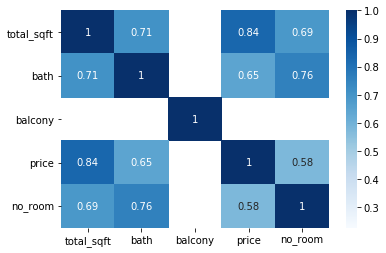

In [32]:
sns.heatmap(df.corr(),cmap="Blues",mask=df.corr()<0.5,annot=True)

In [33]:
df.drop(columns=["area_type","availability"],inplace=True)
df.head()

,location,total_sqft,bath,balcony,price,room,no_room
480,Attibele,450,1.0,1.0,11.00,BHK,1
483,Attibele,400,1.0,1.0,11.00,BHK,1
484,Attibele,400,1.0,1.0,12.00,BHK,1
485,Attibele,400,1.0,1.0,14.00,BHK,1
487,Attibele,395,1.0,1.0,10.25,BHK,1


### Graphs

###### Number of plots within same price range.

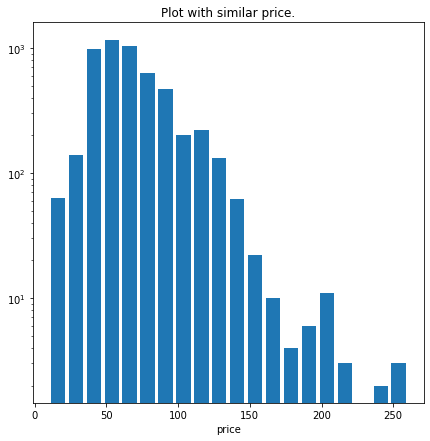

In [34]:
plt.figure(figsize=(7,7))
plt.hist(df.price,bins=20, rwidth=0.8)
plt.title("Plot with similar price.")
plt.xlabel("price")
plt.yscale("log")

###### Relation between the Area and Price of the Plot

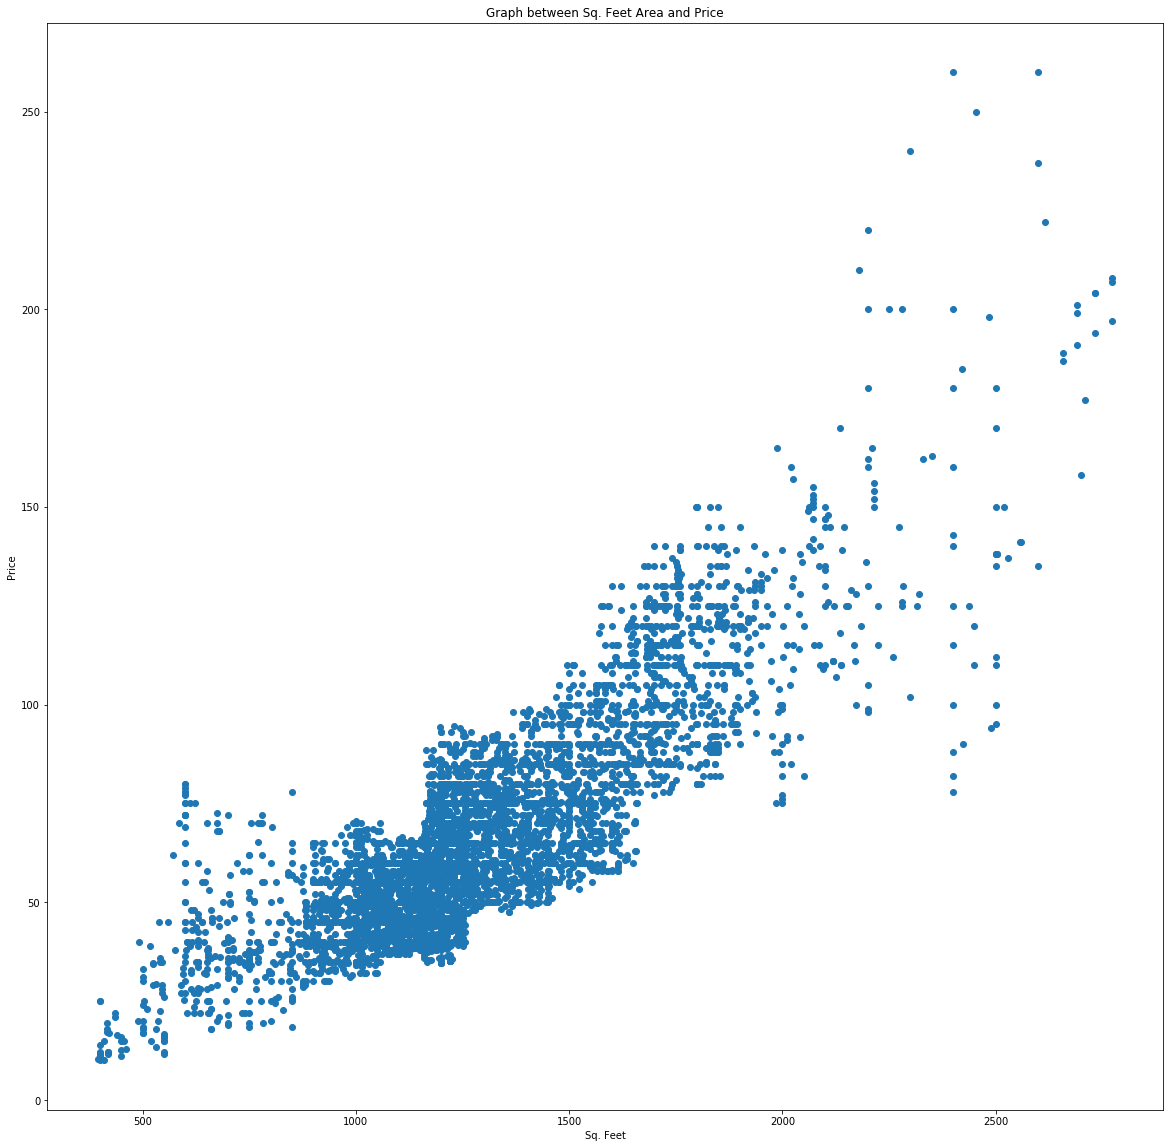

In [35]:
plt.figure(figsize=(20,20))
plt.title("Graph between Sq. Feet Area and Price")
plt.xlabel("Sq. Feet")
plt.ylabel("Price")
plt.scatter(df.total_sqft,df.price)
plt.show()

###### Plot of number of room and the respective price.

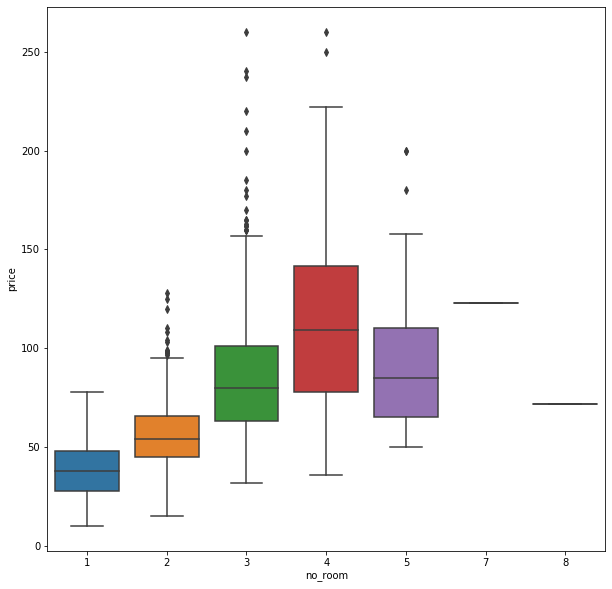

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(df.no_room,df.price)
plt.show()

In [37]:
df.index=(range(len(df)))

In [38]:
df.index=(range(len(df)))

In [39]:
lon=df.location.unique()
lon.sort()

### Encoding

In [40]:
le=LabelEncoder()
df.location=le.fit_transform(df.location)
df.room=le.fit_transform(df.room)

In [41]:
l=pd.DataFrame(df.location,columns=["location"])
ct3=ColumnTransformer([("location",OneHotEncoder(),[0])],remainder="passthrough")

In [42]:
l=pd.DataFrame(ct3.fit_transform(l).todense(),columns=lon)

In [43]:
df=pd.concat([df,l],axis=1)

In [44]:
df.shape

(5159, 151)

In [45]:
df.drop("location",axis=1,inplace=True)

In [46]:
df.shape

(5159, 150)

In [47]:
df.head()

,total_sqft,bath,balcony,price,room,no_room,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Ulsoor,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,450,1.0,1.0,11.00,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,400,1.0,1.0,11.00,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,400,1.0,1.0,12.00,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,400,1.0,1.0,14.00,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,395,1.0,1.0,10.25,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df.dropna(inplace=True)

In [49]:
df.drop_duplicates(inplace=True)

In [50]:
df.shape

(5107, 150)

### Training and Testing

In [51]:
X=df.drop("price",axis=1)
y=df.price

In [52]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [54]:
Data={}

In [55]:
lr=LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)
Data["lr"]=lr.score(X_test,y_test)

In [56]:
la=Lasso()
la.fit(X_train,y_train)
la.score(X_test,y_test)
Data["la"]=la.score(X_test,y_test)

In [57]:
rfc=RandomForestRegressor()
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)
Data["rfc"]=rfc.score(X_test,y_test)

In [58]:
dtr=DecisionTreeRegressor()
dtr.fit(X_train,y_train)
dtr.score(X_test,y_test)
Data["dtr"]=dtr.score(X_test,y_test)

In [59]:
en=ElasticNet()
en.fit(X_train,y_train)
en.score(X_test,y_test)
Data["en"]=en.score(X_test,y_test)

In [60]:
rid=Ridge()
rid.fit(X_train,y_train)
rid.score(X_test,y_test)
Data["rid"]=rid.score(X_test,y_test)

In [61]:
svr=SVR()
svr.fit(X_train,y_train)
svr.score(X_test,y_test)
Data["svr"]=svr.score(X_test,y_test)

In [62]:
Data

{'lr': -1.1747179087179493e+24,
 'la': 0.7126457546151976,
 'rfc': 0.7852240913010364,
 'dtr': 0.682139902117145,
 'en': 0.6928666406090682,
 'rid': 0.751244297242834,
 'svr': 0.48614528677295243}

In [63]:
clf=GridSearchCV(LinearRegression(),param_grid={},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
clf.best_score_

0.7867021355354084

In [64]:
clf=GridSearchCV(Ridge(),param_grid={"alpha":[0.1,0.5,1,2]},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
clf.best_score_

0.7867240745265316

In [65]:
clf=GridSearchCV(Lasso(),param_grid={"alpha":[0.1,0.5,1,2]},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
clf.best_score_

0.7876828683918088

In [66]:
clf=GridSearchCV(SVR(),param_grid={"gamma":["auto","scaler"],"kernel":["rbf","linear"]},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
clf.best_score_

0.7780137274957809

In [67]:
clf=GridSearchCV(RandomForestRegressor(),param_grid={"n_estimators":[1,10,20,50,100,200,300]},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
print(clf.best_score_,clf.best_params_)

0.8009430264234668 {'n_estimators': 300}


## Saving the best model for predicition

In [68]:
clf=GridSearchCV(RandomForestRegressor(),param_grid={"n_estimators":[300]},cv=3,return_train_score=False)
clf.fit(X_train,y_train)
clf.best_score_

0.8009420516709219

In [71]:
joblib.dump(clf,"Bengaluru_trained")

['Bengaluru_trained']

In [72]:
joblib.dump(y_test,"Bengaluru_test_result")

['Bengaluru_test_result']

In [73]:
joblib.dump(X_test,"Bengaluru_test")

['Bengaluru_test']

#### Trying to load Data and Predict

In [74]:
model=joblib.load("Bengaluru_trained")
test_result=joblib.load("Bengaluru_test_result")
test=joblib.load("Bengaluru_test")

In [75]:
test=pd.DataFrame(test)

In [76]:
model.score(test,test_result)

0.7834556183550779